# Graph-level label only membership inference attack (GLO-MIA).
As described here: https://arxiv.org/pdf/2503.19070. This attack method is suitable for multi-graph datasets, and assumes the strictest black box scenario in which the attacker has no access to model architecture, and queries only return labels insteasd of logits/probabilities.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ogb.graphproppred import PygGraphPropPredDataset

In [3]:
import torch
import numpy as np

from tqdm import tqdm
from multiprocessing import Pool
from torch import nn, optim
from torch_geometric import nn as gnn, transforms as T
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader as GDataLoader
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from ml_util import GATProteinsModel, GATMolhivModel, train_model_multi_graph, load_model
from util import onehot_transform, graph_train_test_split, calculate_robustness_scores, _get_onehot_transform

In [4]:
DEVICE = ('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
n_categories = 6
num_feat = 3

# dataset = TUDataset(root='/home/hice1/khom9/scratch/CSE-8803-MLG-Data/PROTEINS', name='PROTEINS', transform=_get_onehot_transform(n_categories))
dataset = TUDataset(root='/home/hice1/khom9/scratch/CSE-8803-MLG-Data/ENZYMES', name='ENZYMES', transform=_get_onehot_transform(n_categories))
# dataset = TUDataset(root='/home/hice1/khom9/scratch/CSE-8803-MLG-Data/DD', name='DD', transform=_get_onehot_transform(n_categories))
# dataset = TUDataset(root='/home/hice1/khom9/scratch/CSE-8803-MLG-Data/MUTAG', name='MUTAG', transform=_get_onehot_transform(n_categories))
# dataset = PygGraphPropPredDataset(root='/home/hice1/khom9/scratch/CSE-8803-MLG-Data/ogb-molhiv', name='ogbg-molhiv', transform=_ogb_molhiv_transform) 
dataset = onehot_transform(dataset, categories=list(range(n_categories)))

In [16]:
# Split dataset inhalf for the target model dataset and shadow model dataset
t_dataset, s_dataset = graph_train_test_split(dataset, test_size=0.5)

# Split each dataset into train/test splits
t_dataset_train, t_dataset_test = graph_train_test_split(t_dataset, test_size=0.5)
s_dataset_train, s_dataset_test = graph_train_test_split(s_dataset, test_size=0.2)

In [18]:
# Create and train target model
lr = 0.001
epochs = 100
batch_size = 8
weight_decay = 1e-4
t_model = GATProteinsModel(num_feat=num_feat, num_classes=n_categories).to(DEVICE)
optimizer = optim.Adam(t_model.parameters(), lr=lr, weight_decay=weight_decay)
t_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                       factor=0.5,
                                                       patience=50,
                                                       min_lr=1e-6,
                                                       verbose=True)
weight = compute_class_weight('balanced', classes=np.unique(t_dataset_train.y.argmax(dim=1)), y=t_dataset_train.y.argmax(dim=1).numpy())
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(weight).to(DEVICE))
# t_save_path = 'mia-models/t_model_proteins.pth'
t_save_path = None

train_model_multi_graph(t_model, optimizer, t_dataset_train, loss_fn, epochs, batch_size, val_dataset=t_dataset_test, save_path=t_save_path, save_freq=10, scheduler=t_scheduler, device=DEVICE)
# t_model = load_model(t_model, t_save_path)

Learning rate: 0.001
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x155202159150>
Training for 100 epochs, with batch size=8
Using validation data (150 samples)
Using device: cuda:0

-----Epoch 1/100-----
Batch 10/19 | loss: 1.91568 (0.126s) | train acc: 0.125, train AUC: 0.438
Batch 19/19 | loss: 1.83647 (0.111s) | train acc: 0.153, train AUC: 0.483
Validation: val loss: 1.823 | val acc: 0.187 | val F1: 0.125 | val AUC: 0.556

-----Epoch 2/100-----
Batch 10/19 | loss: 1.78539 (0.118s) | train acc: 0.263, train AUC: 0.555
Batch 19/19 | loss: 1.81746 (0.105s) | train acc: 0.240, train AUC: 0.551
Validation: val loss: 1.826 | val acc: 0.193 | val F1: 0.182 | val AUC: 0.517

-----Epoch 3/100-----
Batch 10/19 | loss: 1.62947 (0.118s) | train acc: 0.338, train AUC: 0.691
Batch 19/19 | loss: 1.77865 (0.105s) | train acc: 0.300, train AUC: 0.655
Validation: val loss: 1.818 | val acc: 0.200 | val F1: 0.158 | val AUC: 0.556

-----Epoch 4/100-----
Batch 10/19 | loss: 1.68153 

In [17]:
# Create and train shadow model
lr = 0.001
epochs = 100
batch_size = 8
weight_decay = 1e-4
s_model = GATProteinsModel(num_feat=num_feat, num_classes=n_categories).to(DEVICE)
optimizer = optim.Adam(s_model.parameters(), lr=lr, weight_decay=weight_decay)
s_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                       factor=0.5,
                                                       patience=50,
                                                       min_lr=1e-6,
                                                       verbose=True)
weight = compute_class_weight('balanced', classes=np.unique(s_dataset_train.y.argmax(dim=1)), y=s_dataset_train.y.argmax(dim=1).numpy())
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(weight).to(DEVICE))
# s_save_path = 'mia-models/s_model_proteins.pth'
s_save_path = None

train_model_multi_graph(s_model, optimizer, s_dataset_train, loss_fn, epochs, batch_size, val_dataset=s_dataset_test, save_path=s_save_path, save_freq=10, device=DEVICE)
# s_model = load_model(s_model, s_save_path)

Learning rate: 0.001
No learning rate scheduling!
Training for 100 epochs, with batch size=8
Using validation data (60 samples)
Using device: cuda:0

-----Epoch 1/100-----
Batch 10/30 | loss: 1.86216 (0.127s) | train acc: 0.188, train AUC: 0.459
Batch 20/30 | loss: 1.79627 (0.126s) | train acc: 0.206, train AUC: 0.512
Batch 30/30 | loss: 1.83973 (0.126s) | train acc: 0.204, train AUC: 0.529
Validation: val loss: 1.834 | val acc: 0.217 | val F1: 0.181 | val AUC: 0.601

-----Epoch 2/100-----
Batch 10/30 | loss: 1.74822 (0.119s) | train acc: 0.250, train AUC: 0.625
Batch 20/30 | loss: 1.69988 (0.119s) | train acc: 0.244, train AUC: 0.646
Batch 30/30 | loss: 1.76220 (0.119s) | train acc: 0.271, train AUC: 0.640
Validation: val loss: 1.857 | val acc: 0.217 | val F1: 0.170 | val AUC: 0.582

-----Epoch 3/100-----
Batch 10/30 | loss: 1.76648 (0.119s) | train acc: 0.287, train AUC: 0.632
Batch 20/30 | loss: 1.64367 (0.119s) | train acc: 0.325, train AUC: 0.666
Batch 30/30 | loss: 1.71468 (0.119

In [25]:
def search_scaler(s_model, s_dataset_train, s_dataset_test, n_perturb_per_graph=1000, scaler_min=0.1, scaler_max=1):
    for scaler in np.arange(scaler_min, scaler_max, 0.1):
        scores_train = calculate_robustness_scores(s_model, s_dataset_train, n_perturb_per_graph=n_perturb_per_graph, scaler=scaler, device=DEVICE)
        scores_test = calculate_robustness_scores(s_model, s_dataset_test, n_perturb_per_graph=n_perturb_per_graph, scaler=scaler, device=DEVICE)
        
        is_member = np.concatenate((np.ones_like(scores_train), np.zeros_like(scores_test)))
        robust_scores = np.concatenate((scores_train, scores_test))
        fpr, tpr, thresholds = roc_curve(is_member, robust_scores)

#         j = tpr-fpr
#         t = thresholds[j.argmax()]
        t = max(thresholds, key=lambda x: roc_auc_score(is_member, robust_scores>x))
        
        pred_member = (robust_scores > t).astype(int)
        acc = accuracy_score(is_member, pred_member)
        auroc = roc_auc_score(is_member, robust_scores)
        f1 = f1_score(is_member, pred_member)
        print(f's={scaler:.3f}:  t={t:.4f}, acc={acc:.4f}, AUC={auroc:.4f}, F1={f1:.4f}')
        
        
def pred_attack(model, dataset, threshold):
    '''
    Get predictions for membership inference predictions for a model.
    
    model: the target model
    dataset: A dataset to perform membership inference with. That is, predict which examples in it were used to train the model
    threshold: Robustness threshold; graphs above this threshold are predicted to be a member
    '''
    
    
    

In [26]:
search_scaler(s_model, s_dataset_train, s_dataset_test, n_perturb_per_graph=1000, scaler_max=5)

s=0.100:  t=inf, acc=0.2000, AUC=0.7677, F1=0.0000
s=0.200:  t=inf, acc=0.2000, AUC=0.8289, F1=0.0000
s=0.300:  t=inf, acc=0.2000, AUC=0.8252, F1=0.0000
s=0.400:  t=inf, acc=0.2000, AUC=0.8026, F1=0.0000
s=0.500:  t=inf, acc=0.2000, AUC=0.7926, F1=0.0000
s=0.600:  t=inf, acc=0.2000, AUC=0.7754, F1=0.0000
s=0.700:  t=inf, acc=0.2000, AUC=0.7585, F1=0.0000
s=0.800:  t=inf, acc=0.2000, AUC=0.7307, F1=0.0000
s=0.900:  t=inf, acc=0.2000, AUC=0.6988, F1=0.0000
s=1.000:  t=inf, acc=0.2000, AUC=0.6578, F1=0.0000
s=1.100:  t=inf, acc=0.2000, AUC=0.6203, F1=0.0000


KeyboardInterrupt: 

In [21]:
s = 0.3
threshold = 0.8920
pred_scores_train = calculate_robustness_scores(t_model, t_dataset_train, scaler=s, device=DEVICE)
pred_scores_test = calculate_robustness_scores(t_model, t_dataset_test, scaler=s, device=DEVICE)

In [22]:
pred_scores = np.concatenate([pred_scores_train, pred_scores_test])
true_scores = np.concatenate([np.ones_like(pred_scores_train), np.zeros_like(pred_scores_test)])

print(f1_score(true_scores, pred_scores>threshold))

0.7936507936507936


In [23]:
print(accuracy_score(true_scores, pred_scores>threshold))

0.7833333333333333


In [24]:
print(roc_auc_score(true_scores, pred_scores))

0.8247111111111112


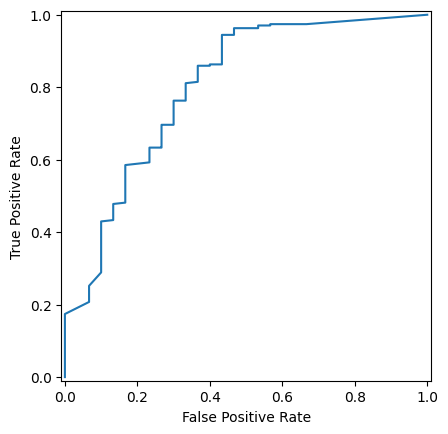

In [39]:
from sklearn.metrics import RocCurveDisplay
fpr, tpr, thresholds = roc_curve(true_scores, pred_scores)

RocCurveDisplay(fpr=fpr, tpr=tpr).plot()